**Import Tensorflow as Neural Network package**

In [1]:
import pandas as pd 
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
import tensorflow as tf

random.seed(11)
np.random.seed(11)

In [2]:
Data = pd.read_csv("../../../4 - Data/04_WorkingDatasets/Top50Combined/50MostImp+CombinedFeatures.csv")
Target = pd.read_csv("../../../4 - Data/04_WorkingDatasets/Top50CombLagged/TargetOutliersTreated.csv")

In [3]:
Target.head()

Data = Data[Data['Datum'] >= '2022-01-02 01:00:00+00:00']
Data.drop(columns = ['Datum'], inplace = True)
Data.head()


,pm10_stundenmittelwerte_ug_m3,pm2_5_stundenmittelwerte_ug_m3,PM10 [ug/m3],PM2.5 [ug/m3],NO2 [ug/m3],NOX [ug/m3 eq. NO2],no2_stundenmittelwerte_ug_m3,CPC [1/cm3],Basel Wind Direction [10 m],Basel Wind Speed [10 m],...,Basel Wind Speed [10 m]_x_Basel Wind Speed [10 m],Basel Wind Speed [10 m]_x_Basel Wind Direction [10 m],Basel Wind Speed [10 m]_x_Gasverbrauch,Basel Wind Speed [10 m]_x_Hour,Basel Wind Direction [10 m]_x_Basel Wind Direction [10 m],Basel Wind Direction [10 m]_x_Hour,406v_sumLW_x_408n_sumLief,660n_sumPW_x_Gasverbrauch,Gasverbrauch_x_Gasverbrauch,Gasverbrauch_x_Hour
25,0.369263,0.761473,0.581652,1.061620,1.256610,1.098958,-0.244049,0.507241,-0.072796,-0.273750,...,-0.419390,-0.174460,-0.285458,-0.066308,-0.899194,-0.024385,0.180482,-0.797138,-0.524208,0.076509
26,0.275948,0.699860,0.309943,0.819359,1.084468,0.836139,-0.300256,0.214210,-0.072796,-0.273750,...,-0.419390,-0.174460,-0.311684,-0.085808,-0.899194,-0.028700,-0.007376,-0.836521,-0.462041,0.126981
27,0.140982,0.567541,0.242016,0.748105,0.984806,0.773562,-0.321188,0.088324,-0.182397,-0.091965,...,-0.446583,-0.177671,-0.222522,-0.064003,-0.876278,-0.056258,0.258004,-0.803148,-0.190749,0.237890
28,-0.001124,0.466301,0.185410,0.719604,0.930446,0.992579,-0.364334,0.444500,-0.243905,0.085512,...,-0.444501,-0.219537,0.004998,-0.015965,-0.853920,-0.085714,0.156083,-0.419025,0.571741,0.464562
29,-0.061715,0.393152,0.151447,0.691103,0.821724,1.092701,-0.289761,0.314072,-0.325010,0.157978,...,-0.435517,-0.255000,0.196703,0.019188,-0.814000,-0.130792,-0.007376,-0.418860,1.440262,0.731748


In [4]:
# Beispiel: Annahme, X.shape[0] = 1000 (1000 Zeitpunkte)
n = Data.shape[0]
X = Data.copy()
y = Target["PM10_Combined_Trend_Residual"].copy()

# Split-Größen definieren
train_size = int(n * 0.7)  # 70% Training
val_size = int(n * 0.1)    # 10% Validierung
test_size = n - train_size - val_size  # 20% Test

# Training (älteste Daten)
X_train, y_train = X[:train_size], y[:train_size]

# Validierung (neuere Daten)
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]

# Test (neueste Daten)
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


In [5]:
tf.random.set_seed(11)

model = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.35),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [7]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

In [8]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])


Epoch 1/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 39.6202 - mae: 4.3198 - mse: 37.0190 - val_loss: 42.1241 - val_mae: 3.7312 - val_mse: 39.7994
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 22.2534 - mae: 3.2719 - mse: 20.0235 - val_loss: 43.2243 - val_mae: 3.8878 - val_mse: 41.2607
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.1080 - mae: 3.0970 - mse: 18.2216 - val_loss: 41.2772 - val_mae: 3.7708 - val_mse: 39.5986
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.7144 - mae: 3.0273 - mse: 17.0968 - val_loss: 40.4173 - val_mae: 3.7561 - val_mse: 38.9489
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.6085 - mae: 3.0107 - mse: 17.1746 - val_loss: 39.3909 - val_mae: 3.7158 - val_mse: 38.0502
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 17.4426 - mae: 2.9416 - mse: 16.1362 - val_loss: 39.7819 - val_mae: 3.7470 - val_mse: 38.5454
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - l

In [9]:
print(X_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in X_test
print(y_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in y_test


(4911, 66)
(4911,)


In [10]:
results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.3849 - mae: 3.8693 - mse: 32.8578 
Test loss, Test MAE: [18.744516372680664, 3.127350330352783, 17.217443466186523]


In [11]:
tf.random.set_seed(11)

model2 = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.35),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model2.evaluate(X_test, y_test)
print("Test loss, Test MAE, Test MSE:", results)

Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 46.1904 - mae: 4.6640 - mse: 43.5042 - val_loss: 43.0588 - val_mae: 3.7842 - val_mse: 40.6543
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 23.8630 - mae: 3.4085 - mse: 21.5503 - val_loss: 41.4482 - val_mae: 3.7599 - val_mse: 39.4178
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 22.1340 - mae: 3.2789 - mse: 20.1747 - val_loss: 42.2904 - val_mae: 3.8402 - val_mse: 40.5361
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.3687 - mae: 3.1657 - mse: 18.6713 - val_loss: 41.2345 - val_mae: 3.7986 - val_mse: 39.6987
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 19.8582 - mae: 3.1622 - mse: 18.3667 - val_loss: 39.7272 - val_mae: 3.7423 - val_mse: 38.3516
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 19.5711 - mae: 3.1296 - mse: 18.2260 - val_loss: 39.9337 - val_mae: 3.8050 - val_mse: 38.6700
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.8956

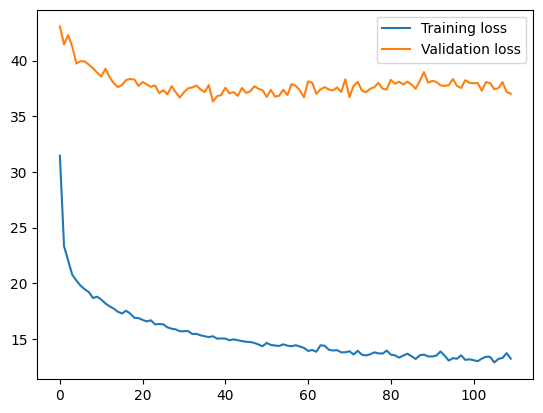

In [12]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [13]:
tf.random.set_seed(11)

model3 = Sequential([
    Dense(512, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.35),
    Dense(256, activation='relu'),
    Dropout(0.38),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='relu'),
])

optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 15 Epochen lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=15, min_lr=1e-6)



history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model3.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)



Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 37.4127 - mae: 4.1440 - mse: 34.5282 - val_loss: 42.0599 - val_mae: 3.7534 - val_mse: 39.5151
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 21.1306 - mae: 3.1708 - mse: 18.7196 - val_loss: 41.2845 - val_mae: 3.7611 - val_mse: 39.2217
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 19.5251 - mae: 3.0809 - mse: 17.5597 - val_loss: 41.4900 - val_mae: 3.7889 - val_mse: 39.7723
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 18.6364 - mae: 3.0258 - mse: 16.9783 - val_loss: 40.4034 - val_mae: 3.7571 - val_mse: 38.8827
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 18.1201 - mae: 2.9786 - mse: 16.6377 - val_loss: 39.1628 - val_mae: 3.7197 - val_mse: 37.7629
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 17.6642 - mae: 2.9482 - mse: 16.3015 - val_loss: 39.2363 - val_mae: 3.7208 - val_mse: 37.9385
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 16.6830

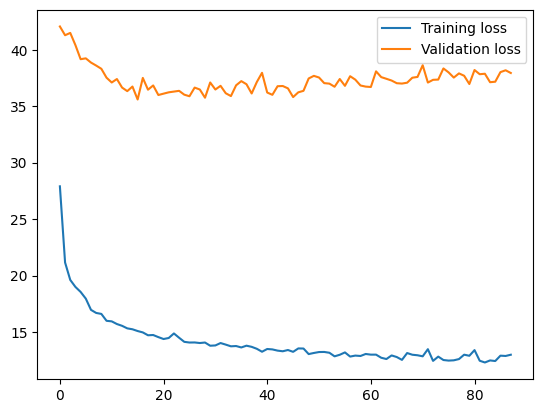

In [14]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


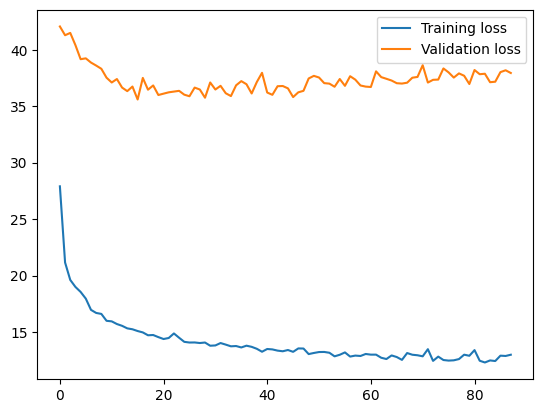

In [15]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [16]:
tf.random.set_seed(11)

model4 = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.35),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model4.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 15 Epochen lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)


history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model4.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 59.5739 - mae: 5.3722 - mse: 56.5951 - val_loss: 43.7816 - val_mae: 3.9082 - val_mse: 41.2440
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.1866 - mae: 3.0914 - mse: 17.8247 - val_loss: 41.7589 - val_mae: 3.7887 - val_mse: 39.7859
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.1996 - mae: 2.9582 - mse: 16.3313 - val_loss: 41.4939 - val_mae: 3.7911 - val_mse: 39.8551
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 17.4244 - mae: 2.9055 - mse: 15.8436 - val_loss: 40.5690 - val_mae: 3.7804 - val_mse: 39.1167
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.8209 - mae: 2.8739 - mse: 15.4181 - val_loss: 40.4015 - val_mae: 3.7772 - val_mse: 39.0941
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.5736 - mae: 2.8542 - mse: 15.2952 - val_loss: 39.9375 - val_mae: 3.7805 - val_mse: 38.7176
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.1519